# Battle of the Neighborhoods - London

## Finding the right move in London

## 1. Introduction 

This project is focused on analysing different boroughs in London, UK. The aim is to assist people who are interested in moving to London but are unsure of what area of London to move to. This project will provide clarity regarding the various amenities in each borough while also providing a score of how expensive each borough is.

This notebook consists of the data acquisition, data cleaning and analysis. Where a K-means clustering approach was taken to cluster the boroughs of London depending on nearby venues. The location and venues data was collect from Foursquare and other London related data is found below:

- Data for London Boroughs: https://en.wikipedia.org/wiki/List_of_London_boroughs
- Data for renting prices for each Borough: https://data.london.gov.uk/dataset/average-private-rents-borough

Importing Modules

In [356]:
import pandas as pd
import numpy as np
import os

from bs4 import BeautifulSoup as BS
import requests

import folium
from geopy.geocoders import Nominatim

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

In [357]:
os.chdir("/Users/Jonathan Challenger/OneDrive")

## 2. Data acquisition 

### Scraping Boroughs table from wiki page

In [358]:
url = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
data = requests.get(url).text
soup = BS(data, 'html5lib')

In [359]:
tables = soup.find_all('table')
london = pd.read_html(str(tables[0]), flavor = 'bs4')[0]
london.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2019 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,212906,".mw-parser-output .geo-default,.mw-parser-outp...",25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,395896,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,248287,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,329771,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,332336,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


### Only keeping the relevant columns.

In [360]:
london.drop(columns=['Inner', 'Status', 'Local authority', 'Political control', 'Headquarters', 'Area (sq mi)', 'Nr. in map', 'Co-ordinates'], axis=1, inplace=True)

In [361]:
london.rename(columns={'Population (2019 est)[1]':'Population'}, inplace=True)

### Cleaning the data in the Borough column.

In [362]:
london['Borough'] = london['Borough'].str.replace('note', '')
london['Borough'] = london['Borough'].map(lambda x: x.rstrip(']'))
london['Borough'] = london['Borough'].map(lambda x: x.rstrip('1234567890'))
london['Borough'] = london['Borough'].map(lambda x: x.rstrip(' ['))
london.head()

,Borough,Population
0,Barking and Dagenham,212906
1,Barnet,395896
2,Bexley,248287
3,Brent,329771
4,Bromley,332336


In [363]:
bos = []
for i in london['Borough']:
    bos.append(i)

### Finding the latitude and longitude of each borough using geopy.

In [364]:
lats = []
longs = []
for i in bos:
    geolocator = Nominatim(user_agent="london_explorer")
    location = geolocator.geocode("{}, London".format(i))
    latitude = location.latitude
    lats.append(latitude)
    longitude = location.longitude
    longs.append(longitude)
    print('The geograpical coordinates of {} are {}, {}.'.format(i, latitude, longitude))

The geograpical coordinates of Barking and Dagenham are 51.5541171, 0.15050434261994267.
The geograpical coordinates of Barnet are 51.65309, -0.2002261.
The geograpical coordinates of Bexley are 51.4416793, 0.150488.
The geograpical coordinates of Brent are 51.563825800000004, -0.2757596561855699.
The geograpical coordinates of Bromley are 51.4028046, 0.0148142.
The geograpical coordinates of Camden are 51.5423045, -0.1395604.
The geograpical coordinates of Croydon are 51.3713049, -0.101957.
The geograpical coordinates of Ealing are 51.5126553, -0.3051952.
The geograpical coordinates of Enfield are 51.6520851, -0.0810175.
The geograpical coordinates of Greenwich are 51.4820845, -0.0045417.
The geograpical coordinates of Hackney are 51.5432402, -0.0493621.
The geograpical coordinates of Hammersmith and Fulham are 51.4920377, -0.2236401.
The geograpical coordinates of Haringey are 51.6014736, -0.1117815.
The geograpical coordinates of Harrow are 51.596827149999996, -0.33731605402671094.


In [365]:
london['Latitude'] = pd.Series(lats)
london['Longitude'] = pd.Series(longs)

In [366]:
london.head()

,Borough,Population,Latitude,Longitude
0,Barking and Dagenham,212906,51.554117,0.150504
1,Barnet,395896,51.653090,-0.200226
2,Bexley,248287,51.441679,0.150488
3,Brent,329771,51.563826,-0.275760
4,Bromley,332336,51.402805,0.014814


### Opening the rent price dataframe.

In [367]:
rent_df = pd.read_csv("rent_borough.csv", header=None)
rent_df.columns = ['Code', 'Borough', 'Avg. Price']
rent_df.head()

,Code,Borough,Avg. Price
0,E09000001,City of London,"2,377"
1,E09000002,Barking and Dagenham,"1,192"
2,E09000003,Barnet,"1,548"
3,E09000004,Bexley,"1,084"
4,E09000005,Brent,"1,578"


In [368]:
rent_df.drop(rent_df.index[0], inplace=True)

In [369]:
rent_df.drop('Code', axis=1, inplace=True)

### Merging the borough dataframe with the rent price dataframe.

In [370]:
london_df = london.join(rent_df.set_index('Borough'), on='Borough')

In [371]:
london_df.head()

,Borough,Population,Latitude,Longitude,Avg. Price
0,Barking and Dagenham,212906,51.554117,0.150504,"1,192"
1,Barnet,395896,51.653090,-0.200226,"1,548"
2,Bexley,248287,51.441679,0.150488,"1,084"
3,Brent,329771,51.563826,-0.275760,"1,578"
4,Bromley,332336,51.402805,0.014814,"1,318"


### Converting price column to integer values

In [372]:
london_df['Avg. Price'] = london_df['Avg. Price'].str.replace(',','')

In [373]:
london_df['Avg. Price'] = london_df['Avg. Price'].astype(int)

### Creating a rent score by normalising rent values within the dataset where the cheapest rent is the best score.

In [374]:
denom = london_df['Avg. Price'].max() - london_df['Avg. Price'].min()
london_df['Rent_score'] = 1 - ((london_df['Avg. Price'] - london_df['Avg. Price'].min() ) / denom)

### Final dataframe before analysis.

In [375]:
london_df.head()

,Borough,Population,Latitude,Longitude,Avg. Price,Rent_score
0,Barking and Dagenham,212906,51.554117,0.150504,1192,0.949153
1,Barnet,395896,51.653090,-0.200226,1548,0.781544
2,Bexley,248287,51.441679,0.150488,1084,1.000000
3,Brent,329771,51.563826,-0.275760,1578,0.767420
4,Bromley,332336,51.402805,0.014814,1318,0.889831


## 3. Analysis

### Visualising the renting prices across London boroughs.

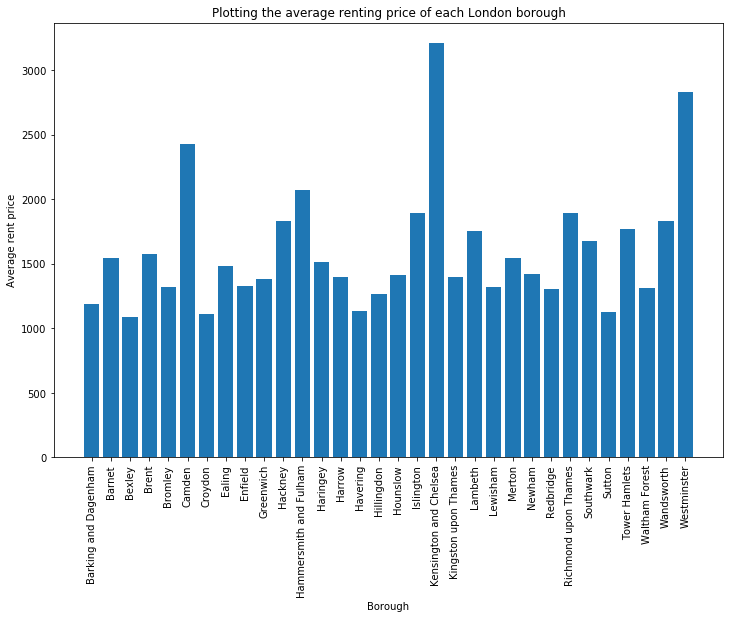

In [376]:
plt.figure(figsize=(12,8))
plt.bar(london_df['Borough'], london_df['Avg. Price'])
plt.xticks(rotation=90)
plt.xlabel("Borough")
plt.ylabel("Average rent price")
plt.title("Plotting the average renting price of each London borough")
plt.show()

### Finding coordinates of London and plotting all boroughs on a map of London.

In [377]:
address = "London, UK"

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [378]:
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough in zip(
        london_df['Latitude'], 
        london_df['Longitude'], 
        london_df['Borough'], ):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  

map_london

### Foursquare credentials.

In [379]:
# Removed for privacy reasons
CLIENT_ID = ''
CLIENT_SECRET = '' 
VERSION = '' 
LIMIT = 150

### Defining function to get venue data from Foursquare for each borough.

In [380]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [381]:
london_venues = getNearbyVenues(names=london_df['Borough'], 
                                 latitudes = london_df['Latitude'], 
                                 longitudes = london_df['Longitude'])

In [382]:
london_venues.head()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.554117,0.150504,Tesco Express,51.551536,0.152784,Grocery Store
1,Barking and Dagenham,51.554117,0.150504,Connor Road Bus Stop,51.554345,0.147162,Bus Stop
2,Barking and Dagenham,51.554117,0.150504,Oglethorpe Road Bus Stop,51.555221,0.147136,Bus Stop
3,Barking and Dagenham,51.554117,0.150504,Five Elms Off Licence,51.553878,0.145531,Liquor Store
4,Barnet,51.653090,-0.200226,Ye Old Mitre Inne,51.652940,-0.199507,Pub


### Plotting the number of venues for each borough.

In [383]:
bo_counts = london_venues['Borough'].value_counts().rename_axis("Borough").reset_index(name='Count')
bo_counts.head()

,Borough,Count
0,Southwark,100
1,Kingston upon Thames,100
2,Ealing,99
3,Hammersmith and Fulham,90
4,Camden,90


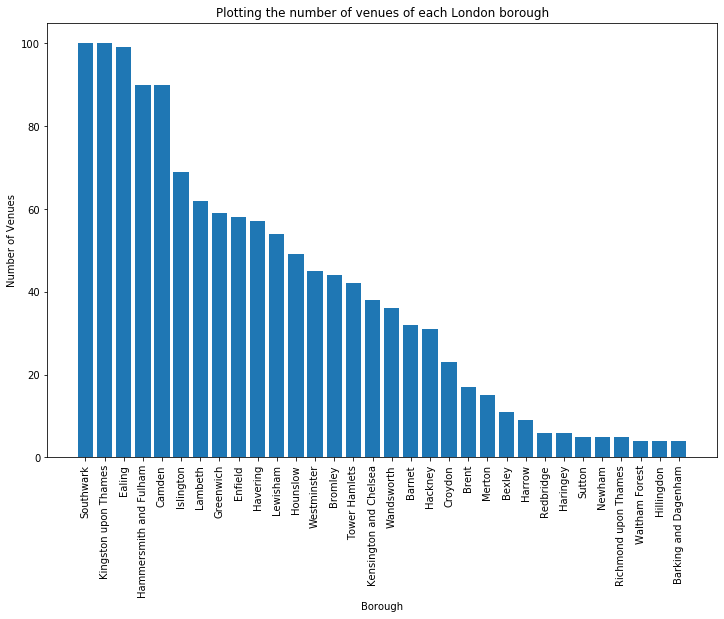

In [384]:
plt.figure(figsize=(12,8))
plt.bar(bo_counts['Borough'], bo_counts['Count'])
plt.xticks(rotation=90)
plt.xlabel("Borough")
plt.ylabel("Number of Venues")
plt.title("Plotting the number of venues of each London borough")
plt.show()

### Only using boroughs with 10 or more venues nearby.

In [385]:
london_venues = london_venues.join(bo_counts.set_index('Borough'), on ='Borough')
london_venues = london_venues[london_venues['Count'] >= 10]

### Creating a dataframe with one hot encoding to show which categories of venue are present in each borough.

In [386]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Borough'] = london_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Borough,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,...,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
4,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Creating dataframe showing the frequency of each category of venues in each borough.

In [387]:
london_grouped = london_onehot.groupby('Borough').mean().reset_index()
london_grouped.head()

,Borough,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,...,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Barnet,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,Bexley,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,Brent,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,Bromley,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.022727,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,Camden,0.0,0.0,0.011111,0.011111,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.022222,0.0,0.022222,0.0,0.0,0.0,0.0,0.0


### Defining function to find top 10 most common venues in each borough.

In [388]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Creating dataframe with the top 10 most common venues in each borough.

In [389]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnet,Coffee Shop,Convenience Store,Italian Restaurant,Pharmacy,Pub,Park,Restaurant,Bookstore,Pizza Place,Grocery Store
1,Bexley,Pub,Fast Food Restaurant,Train Station,Greek Restaurant,Convenience Store,Indian Restaurant,Breakfast Spot,Toy / Game Store,Italian Restaurant,Farm
2,Brent,Coffee Shop,Hotel,Supermarket,Food Court,Sports Bar,Café,Fast Food Restaurant,Electronics Store,Pedestrian Plaza,Sandwich Place
3,Bromley,Clothing Store,Coffee Shop,Gym / Fitness Center,Pub,Burger Joint,Pizza Place,Portuguese Restaurant,Movie Theater,Chocolate Shop,Theater
4,Camden,Pub,Coffee Shop,Café,Burger Joint,Ice Cream Shop,Italian Restaurant,Supermarket,Market,Music Venue,Vegetarian / Vegan Restaurant


## 4. Clustering

### Running K-means algorithm with 7 clusters.

In [390]:
k = 7

london_grouped_cluster = london_grouped.drop('Borough', 1)

# Run KMeans Clustering
km = KMeans(n_clusters=k, random_state=0).fit(london_grouped_cluster)

### Merging London dataframe with most common venues with cluster label column.

In [391]:
boroughs_venues_sorted.insert(0, 'Cluster Labels', km.labels_)

In [392]:
london_merged = london_df.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')

london_merged.dropna(axis=0, inplace = True)

london_merged = london_merged.reset_index(drop=True)

london_merged['Cluster Labels'] = london_merged['Cluster Labels'].astype(int)

london_merged.head()

,Borough,Population,Latitude,Longitude,Avg. Price,Rent_score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnet,395896,51.653090,-0.200226,1548,0.781544,6,Coffee Shop,Convenience Store,Italian Restaurant,Pharmacy,Pub,Park,Restaurant,Bookstore,Pizza Place,Grocery Store
1,Bexley,248287,51.441679,0.150488,1084,1.000000,2,Pub,Fast Food Restaurant,Train Station,Greek Restaurant,Convenience Store,Indian Restaurant,Breakfast Spot,Toy / Game Store,Italian Restaurant,Farm
2,Brent,329771,51.563826,-0.275760,1578,0.767420,4,Coffee Shop,Hotel,Supermarket,Food Court,Sports Bar,Café,Fast Food Restaurant,Electronics Store,Pedestrian Plaza,Sandwich Place
3,Bromley,332336,51.402805,0.014814,1318,0.889831,0,Clothing Store,Coffee Shop,Gym / Fitness Center,Pub,Burger Joint,Pizza Place,Portuguese Restaurant,Movie Theater,Chocolate Shop,Theater
4,Camden,270029,51.542305,-0.139560,2427,0.367702,3,Pub,Coffee Shop,Café,Burger Joint,Ice Cream Shop,Italian Restaurant,Supermarket,Market,Music Venue,Vegetarian / Vegan Restaurant


### Visualising the clusters over a map of London.

In [393]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        london_merged['Latitude'], 
        london_merged['Longitude'], 
        london_merged['Borough'], 
        london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

### Defining funciton to examine each borough in each cluster

In [394]:
def examine_clusters(cluster_label):
    return london_merged.loc[london_merged['Cluster Labels'] == cluster_label, :]

### Cluster 1

In [395]:
examine_clusters(0)

,Borough,Population,Latitude,Longitude,Avg. Price,Rent_score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bromley,332336,51.402805,0.014814,1318,0.889831,0,Clothing Store,Coffee Shop,Gym / Fitness Center,Pub,Burger Joint,Pizza Place,Portuguese Restaurant,Movie Theater,Chocolate Shop,Theater
7,Enfield,333794,51.652085,-0.081018,1325,0.886535,0,Clothing Store,Coffee Shop,Supermarket,Pub,Bookstore,Optical Shop,Department Store,Pharmacy,Fish & Chips Shop,Video Game Store
12,Hounslow,271523,51.468613,-0.361347,1410,0.846516,0,Coffee Shop,Clothing Store,Grocery Store,Indian Restaurant,Fast Food Restaurant,Hotel,Bakery,Pharmacy,Sandwich Place,Café
17,Lewisham,305842,51.462432,-0.010133,1318,0.889831,0,Clothing Store,Coffee Shop,Fast Food Restaurant,Pharmacy,Restaurant,Supermarket,Bus Stop,Café,Fish & Chips Shop,Grocery Store
21,Wandsworth,329677,51.457027,-0.193261,1828,0.649718,0,Coffee Shop,Clothing Store,Pub,Asian Restaurant,Gym / Fitness Center,Supermarket,Bookstore,Chocolate Shop,Breakfast Spot,Stationery Store


### Cluster 2

In [396]:
examine_clusters(1)

,Borough,Population,Latitude,Longitude,Avg. Price,Rent_score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Greenwich,287942,51.482084,-0.004542,1380,0.860640,1,Pub,Boat or Ferry,Pizza Place,Bakery,History Museum,Garden,Market,Coffee Shop,Pier,Burger Joint
13,Islington,242467,51.538429,-0.099905,1895,0.618173,1,Pub,Burger Joint,Mediterranean Restaurant,Arts & Crafts Store,Café,Theater,Bakery,Bookstore,Breakfast Spot,Cocktail Bar


### Cluster 3

In [397]:
examine_clusters(2)

,Borough,Population,Latitude,Longitude,Avg. Price,Rent_score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bexley,248287,51.441679,0.150488,1084,1.0,2,Pub,Fast Food Restaurant,Train Station,Greek Restaurant,Convenience Store,Indian Restaurant,Breakfast Spot,Toy / Game Store,Italian Restaurant,Farm


### Cluster 4

In [398]:
examine_clusters(3)

,Borough,Population,Latitude,Longitude,Avg. Price,Rent_score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Camden,270029,51.542305,-0.139560,2427,0.367702,3,Pub,Coffee Shop,Café,Burger Joint,Ice Cream Shop,Italian Restaurant,Supermarket,Market,Music Venue,Vegetarian / Vegan Restaurant
5,Croydon,386710,51.371305,-0.101957,1112,0.986817,3,Pub,Coffee Shop,Caribbean Restaurant,Bookstore,Nightclub,Korean Restaurant,Malay Restaurant,Café,Clothing Store,Italian Restaurant
6,Ealing,341806,51.512655,-0.305195,1484,0.811676,3,Coffee Shop,Pub,Café,Platform,Bus Stop,Clothing Store,Burger Joint,Park,Grocery Store,Bakery
9,Hackney,281120,51.543240,-0.049362,1834,0.646893,3,Coffee Shop,Pub,Brewery,Café,Supermarket,Modern European Restaurant,Movie Theater,Park,Pizza Place,Beer Store
10,Hammersmith and Fulham,185143,51.492038,-0.223640,2070,0.535782,3,Pub,Café,Coffee Shop,Gym / Fitness Center,Sandwich Place,Hotel,Grocery Store,Pizza Place,Thai Restaurant,Burger Joint
11,Havering,259552,51.544385,-0.144307,1131,0.977872,3,Café,Coffee Shop,Pub,Flea Market,Ice Cream Shop,Platform,Supermarket,Outdoor Sculpture,Market,Grocery Store
14,Kensington and Chelsea,156129,51.498480,-0.199043,3208,0.000000,3,Café,Persian Restaurant,Clothing Store,History Museum,Pub,Burger Joint,Italian Restaurant,Supermarket,Middle Eastern Restaurant,Juice Bar
15,Kingston upon Thames,177507,51.409627,-0.306262,1396,0.853107,3,Coffee Shop,Café,Italian Restaurant,Pub,Clothing Store,Sandwich Place,Bakery,Department Store,Hotel,Thai Restaurant
16,Lambeth,326034,51.501301,-0.117287,1751,0.685970,3,Coffee Shop,Bar,Hotel,Café,Korean Restaurant,Bakery,Sandwich Place,Beer Bar,Movie Theater,Event Space
19,Southwark,318830,51.502922,-0.103458,1676,0.721281,3,Hotel,Pub,Coffee Shop,Gym / Fitness Center,Sandwich Place,Italian Restaurant,Bar,Bakery,Cocktail Bar,Café


### Cluster 5

In [399]:
examine_clusters(4)

,Borough,Population,Latitude,Longitude,Avg. Price,Rent_score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Brent,329771,51.563826,-0.27576,1578,0.76742,4,Coffee Shop,Hotel,Supermarket,Food Court,Sports Bar,Café,Fast Food Restaurant,Electronics Store,Pedestrian Plaza,Sandwich Place


### Cluster 6

In [400]:
examine_clusters(5)

,Borough,Population,Latitude,Longitude,Avg. Price,Rent_score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Merton,206548,51.41087,-0.188097,1542,0.784369,5,Tram Station,Pub,Cricket Ground,Park,Flea Market,Farm,Brazilian Restaurant,Steakhouse,Hardware Store,Dessert Shop


### Cluster 7

In [401]:
examine_clusters(6)

,Borough,Population,Latitude,Longitude,Avg. Price,Rent_score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnet,395896,51.653090,-0.200226,1548,0.781544,6,Coffee Shop,Convenience Store,Italian Restaurant,Pharmacy,Pub,Park,Restaurant,Bookstore,Pizza Place,Grocery Store
20,Tower Hamlets,324745,51.525629,-0.033585,1773,0.675612,6,Pizza Place,Pub,Bus Stop,Coffee Shop,Grocery Store,Canal Lock,Road,Sandwich Place,Climbing Gym,Breakfast Spot
